# Demographic analysis

This notebook puts together a bunch of demographic analyses, and exports cleaned data to Stata for regression.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
from nhts import estReplicateSE, multiReplicateSE, weighted_percentile
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from os.path import abspath
import re
import os
import matplotlib.image
from functools import partial

WEIGHT = 'WTPERFIN'

## Load data

Load the person data, household data, and replicate weights, and merge them all into the person data frame.

In [2]:
pers17 = pd.read_csv('../data/2017/perpub.csv')
repl17 = pd.read_csv('../data/2017/perwgt.csv')
pers17 = pers17.merge(repl17.drop(['WTPERFIN'], 1), on=['HOUSEID', 'PERSONID'], how='left', validate='1:1')
del repl17

hh17 = pd.read_csv('../data/2017/hhpub.csv')
pers17 = pers17.merge(hh17, on='HOUSEID', how='left', validate='m:1', suffixes=('', 'hh'))

## Clean data and add derived columns

The cells below do data cleaning and computation of derived columns.

### Day of Week

In [3]:
pers17['dayOfWeek'] = pers17.TRAVDAY.replace({
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday'
}).astype('category').cat\
    .reorder_categories(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

### Convert CBSA codes to names

In [4]:
pers17['cbsaName'] = pers17.HH_CBSA.replace({'12060': 'Atlanta-Sandy Springs-Roswell, GA',
 '12420': 'Austin-Round Rock, TX',
 '12580': 'Baltimore-Columbia-Towson, MD',
 '13820': 'Birmingham-Hoover, AL',
 '14460': 'Boston-Cambridge-Newton, MA-NH',
 '15380': 'Buffalo-Cheektowaga-Niagara Falls, NY',
 '16740': 'Charlotte-Concord-Gastonia, NC-SC',
 '16980': 'Chicago-Naperville-Elgin, IL-IN-WI',
 '17140': 'Cincinnati, OH-KY-IN',
 '17460': 'Cleveland-Elyria, OH',
 '18140': 'Columbus, OH',
 '19100': 'Dallas-Fort Worth-Arlington, TX',
 '19740': 'Denver-Aurora-Lakewood, CO',
 '19820': 'Detroit-Warren-Dearborn, MI',
 '24340': 'Grand Rapids-Wyoming, MI',
 '25540': 'Hartford-West Hartford-East Hartford, CT',
 '26420': 'Houston-The Woodlands-Sugar Land, TX',
 '26900': 'Indianapolis-Carmel-Anderson, IN',
 '27260': 'Jacksonville, FL',
 '28140': 'Kansas City, MO-KS',
 '29820': 'Las Vegas-Henderson-Paradise, NV',
 '31080': 'Los Angeles-Long Beach-Anaheim, CA',
 '31140': 'Louisville/Jefferson County, KY-IN',
 '32820': 'Memphis, TN-MS-AR',
 '33100': 'Miami-Fort Lauderdale-West Palm Beach, FL',
 '33340': 'Milwaukee-Waukesha-West Allis, WI',
 '33460': 'Minneapolis-St. Paul-Bloomington, MN-WI',
 '34980': 'Nashville-Davidson--Murfreesboro--Franklin, TN',
 '35380': 'New Orleans-Metairie, LA',
 '35620': 'New York-Newark-Jersey City, NY-NJ-PA',
 '36420': 'Oklahoma City, OK',
 '36740': 'Orlando-Kissimmee-Sanford, FL',
 '37980': 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD',
 '38060': 'Phoenix-Mesa-Scottsdale, AZ',
 '38300': 'Pittsburgh, PA',
 '38900': 'Portland-Vancouver-Hillsboro, OR-WA',
 '39300': 'Providence-Warwick, RI-MA',
 '39580': 'Raleigh, NC',
 '40060': 'Richmond, VA',
 '40140': 'Riverside-San Bernardino-Ontario, CA',
 '40380': 'Rochester, NY',
 '40900': 'Sacramento--Roseville--Arden-Arcade, CA',
 '41180': 'St. Louis, MO-IL',
 '41620': 'Salt Lake City, UT',
 '41700': 'San Antonio-New Braunfels, TX',
 '41740': 'San Diego-Carlsbad, CA',
 '41860': 'San Francisco-Oakland-Hayward, CA',
 '41940': 'San Jose-Sunnyvale-Santa Clara, CA',
 '42660': 'Seattle-Tacoma-Bellevue, WA',
 '45300': 'Tampa-St. Petersburg-Clearwater, FL',
 '47260': 'Virginia Beach-Norfolk-Newport News, VA-NC',
 '47900': 'Washington-Arlington-Alexandria, DC-VA-MD-WV',
 'XXXXX': 'Suppressed'}).astype('category')

### Add an estimated geographic cell

The NHTS oversampled some "add-on" areas. We create a dummy variables for those areas as well as the Census divisions that were used in the NHTS weighting scheme. Some of the add-on areas, such as Arizona, constituted entire states. In these cases, we include a dummy variable for that state. Other add-on areas, such as Des Moines, are sub-state areas that are also not reported as a metro area. These are not controlled directly, but a dummy variable for the state containing them is controlled for. For states with no add-on areas, the Census division is controlled for.

This means that any differences between areas will be controlled for. However, if there are different _relationships_ between areas (for example, if older people are more likely to use ridehailing in some parts of the country), those estimates may still be biased, if those parts of the country were over or undersampled.

In [5]:
# Compute the geographic cell, so the regression can correct for the sampling plan
# See page 3-3 of the weighting report, https://nhts.ornl.gov/assets/2017%20NHTS%20Weighting%20Report.pdf
def computeGeographicCell (row):
    if row.HHSTATE == 'AZ':
        return 'Arizona'
    elif row.HHSTATE == 'CA':
        return 'California'
    elif row.HHSTATE == 'GA':
        return 'Georgia'
    # We don't know where in Iowa, Texas, or Oklahoma respondents live,
    # so just create single "Iowa", "Oklahoma" and "Texas" cell
    elif row.HHSTATE == 'IA':
        return 'Iowa'
    elif row.HHSTATE == 'OK':
        return 'Oklahoma'
    elif row.HHSTATE == 'TX':
        return 'Texas'
    elif row.HHSTATE == 'MD':
        return 'Maryland'
    elif row.HHSTATE == 'NC':
        return 'North Carolina'
    elif row.HHSTATE == 'NY':
        return 'New York State'
    elif row.HHSTATE == 'SC':
        return 'South Carolina'
    elif row.HHSTATE == 'WI':
        return 'Wisconsin'
    elif row.HHSTATE in ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']:
        return 'Census division 1 (New England)'
    elif row.HHSTATE in ['NJ', 'PA']:
        return 'Census division 2 (Northeast) balance'
    elif row.HHSTATE in ['IN', 'IL', 'MI', 'OH']:
        return 'Census division 3 (northern Midwest) balance'
    elif row.HHSTATE in ['KS', 'MN', 'MO', 'NE', 'ND', 'SD']:
        return 'Census division 4 (Great Plains), balance'
    elif row.HHSTATE in ['DE', 'DC', 'FL', 'VA', 'WV']:
        return 'Census division 5 (Mid-Atlantic and Atlantic South), balance'
    elif row.HHSTATE in ['AL', 'KY', 'MS', 'TN']:
        return 'Census division 6 (South)'
    elif row.HHSTATE in ['AR', 'LA']:
        return 'Census division 7 (N/E of Texas), balance'
    elif row.HHSTATE in ['CO', 'ID', 'NM', 'MT', 'UT', 'NV', 'WY']:
        return 'Census division 8 (Inland West), balance'
    elif row.HHSTATE in ['AK', 'HI', 'OR', 'WA']:
        return 'Census division 9 (Pacific), balance'
    else:
        raise ValueError(f'unknown state {row.HHSTATE}')
    

pers17['geographicCellDerived'] = pers17.apply(computeGeographicCell, 'columns').astype('category')

### Race and Hispanic status

In [6]:
pers17['race'] = pers17.R_RACE.replace({
    -7: np.nan,
    -8: np.nan,
    1: 'White',
    2: 'Black or African American',
    3: 'Asian',
    4: 'American Indian or Alaska Native',
    5: 'Native Hawaiian or other Pacific Islander',
    6: 'Multiple races',
    97: 'Other'
}).astype('category')

# Reorder race categories so Stata will use white as base
pers17['race'] = pers17.race.cat.reorder_categories([
    'White', 'American Indian or Alaska Native', 'Asian',
       'Black or African American', 'Multiple races',
       'Native Hawaiian or other Pacific Islander', 'Other'
])

In [7]:
pers17['isHispanic'] = pers17.R_HISP.replace({
    -7: np.nan,
    -8: np.nan,
    1: 1,
    2: 0
}).astype('float64')

### Homeowner status

In [8]:
pers17['homeowner'] = pers17.HOMEOWN.replace({
    -7: np.nan,
    -8: np.nan,
    1: 1,
    2: 0,
    97: np.nan # "some other arrangement"
}).astype('float64')

### Season of survey

To control for differences in trip making in different seasons.

In [9]:
pers17['season'] = pers17.TDAYDATE.apply(lambda x: x % 100).replace({
    1: 'Winter',
    2: 'Winter',
    3: 'Winter',
    4: 'Spring',
    5: 'Spring',
    6: 'Spring',
    7: 'Summer',
    8: 'Summer',
    9: 'Summer',
    10: 'Fall',
    11: 'Fall',
    12: 'Fall'
}).astype('category')

### Income

We code this both into all of the categories from the NHTS, as well as a smaller number of categories for use in the model.

In [10]:
pers17['income'] = pers17.HHFAMINC.replace({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than $10,000',
    2: '$10,000 to $14,999',
    3: '$15,000 to $24,999',
    4: '$25,000 to $34,999',
    5: '$35,000 to $49,999',
    6: '$50,000 to $74,999',
    7: '$75,000 to $99,999',
    8: '$100,000 to $124,999',
    9: '$125,000 to $149,999',
    10: '$150,000 to $199,999',
    11: '$200,000 or more'
}).astype('category').cat.reorder_categories([
    'Less than $10,000',
    '$10,000 to $14,999',
    '$15,000 to $24,999',
    '$25,000 to $34,999',
    '$35,000 to $49,999',
    '$50,000 to $74,999',
    '$75,000 to $99,999',
    '$100,000 to $124,999',
    '$125,000 to $149,999',
    '$150,000 to $199,999',
    '$200,000 or more'
])

incomeCategories = {
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than \$25,000',
    2: 'Less than \$25,000',
    3: 'Less than \$25,000',
    4: '\$25,000--\$49,999',
    5: '\$25,000--\$49,999',
    6: '\$50,000--\$99,999',
    7: '\$50,000--\$99,999',
    8: '\$100,000 or more',
    9: '\$100,000 or more',
    10: '\$100,000 or more',
    11: '\$100,000 or more'
}

pers17['incomeCategory'] = pers17.HHFAMINC\
    .replace(incomeCategories)\
    .astype('category')\
    .cat\
    .reorder_categories([
        'Less than \$25,000',
        '\$25,000--\$49,999',
        '\$50,000--\$99,999',
        '\$100,000 or more'
    ])

### Age categories

We want to include dummies for age category in the model, to allow the estimation of a nonlinear relationship. Create those age categories. Exclude people under 16 (not asked the ridehailing question) and people who did not report their age (negative values).

Note that we use raw respondent age, not imputed age, because imputed age is not available in Version 1.0 of the 2017 NHTS data, which was used for this project.

In [11]:
pers17['agecat'] = pd.cut(pers17.R_AGE.apply(lambda x: min(x, 89)), [16, 20, 30, 40, 50, 60, 70, 80, 90], right=False)

### Presence of children

Look for young children in household. This requires both the person file and the household file, as the household file contains the number of children under 5, who aren't contained in the person file. The NHTS only surveys children who are 5 or older.

In [12]:
# Add dummies for presence of children
ageByHid = pers17.groupby('HOUSEID').R_AGE.agg({
    'children0to12': lambda x: np.any(x <= 12),
    'children13to17': lambda x: np.any((x > 12) & (x <= 17)),
    'missingAge': lambda x: np.any(pd.isnull(x))
})

pers17 = pers17.merge(ageByHid, left_on='HOUSEID', right_index=True, how='left', validate='m:1')
# If there are children 0-4 in the household, add them to 0-12 variable.
pers17['children0to12'] = pers17.children0to12 | (pers17.YOUNGCHILD > 0)

# if there was an HH member in the appropriate category, it doesn't matter what the ages of the other HH members were
# but if there wasn't, and a respondent had an undefined age, then we don't know if that undefined age might be a child
# There are only 355 households where there are undefined ages
pers17.loc[~pers17.children0to12 & pers17.missingAge, 'children0to12'] = np.nan
pers17.loc[~pers17.children13to17 & pers17.missingAge, 'children13to17'] = np.nan

/Users/matthewc/anaconda/envs/ridehailing-nhts/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


### Additional demographic and built environment characteristics

In [13]:
pers17['lifeCycle'] = pers17.LIF_CYC.replace({
    -9: np.nan,
    1: 'One adult, no children',
    2: '2+ adults, no children',
    3: 'One adult, youngest child 0-5',
    4: '2+ adults, youngest child 0-5',
    5: 'One adult, youngest child 6-15',
    6: '2+ adults, youngest child 6-15',
    7: 'One adult, youngest child 16-21',
    8: '2+ adults, youngest child 16-21',
    9: 'One adult, retired, no children',
    10: '2+ adults, retired, no children'
}).astype('category').cat.reorder_categories([
    'One adult, no children',
    '2+ adults, no children',
    'One adult, youngest child 0-5',
    '2+ adults, youngest child 0-5',
    'One adult, youngest child 6-15',
    '2+ adults, youngest child 6-15',
    'One adult, youngest child 16-21',
    '2+ adults, youngest child 16-21',
    'One adult, retired, no children',
    '2+ adults, retired, no children'
])

pers17['sex'] = pers17.R_SEX.replace({
    -7: np.nan,
    -8: np.nan,
    1: 'Male',
    2: 'Female'
}).astype('category')

pers17['dailyInternetUseHH'] = pers17.WEBUSE17.replace({
    -7: np.nan,
    -9: np.nan,
    1: True,
    2: False,
    3: False,
    4: False,
    5: False
}).astype('bool')

# No missing data for out of town
pers17['outOfTown'] = pers17.OUTOFTWN == 1

# NB always false when vehicle ownership == 0. 0 > 0 == False
pers17['oneVehiclePerDriverOrMore'] = pers17.HHVEHCNT > pers17.DRVRCNT
pers17['driver'] = pers17.DRIVER == 1

pers17['education'] = pers17['EDUC'].replace({
    -1: 'Child',
    -7: np.nan,
    -8: np.nan,
    1: 'Less than HS',
    2: 'HS/GED',
    3: 'Some college/Associate\'s',
    4: 'Bachelor\'s',
    5: 'Graduate/Professional Degree'
}).astype('category').cat.reorder_categories([
    'Less than HS',
    'HS/GED',
    'Some college/Associate\'s',
    'Bachelor\'s',
    'Graduate/Professional Degree',
    'Child'
])

pers17['dailySmartphoneUseHH'] = pers17.SPHONE.replace({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: True,
    2: False,
    3: False,
    4: False,
    5: False
}).astype('bool')

In [14]:
# Density
pers17['density'] = pers17.HBPPOPDN.replace({
    50: '0--99 persons/sq. mi.',
    300: '100--499 persons/sq. mi.',
    750: '500--999 persons/sq. mi.',
    1500: '1,000--1,999 persons/sq. mi.',
    3000: '2,000--3,999 persons/sq. mi.',
    7000: '4,000--9,999 persons/sq. mi.',
    17000: '10,000--24,999 persons/sq. mi.',
    30000: '> 25,000 persons/sq. mi.'
}).astype('category').cat.reorder_categories([
    '0--99 persons/sq. mi.',
    '100--499 persons/sq. mi.',
    '500--999 persons/sq. mi.',
    '1,000--1,999 persons/sq. mi.',
    '2,000--3,999 persons/sq. mi.',
    '4,000--9,999 persons/sq. mi.',
    '10,000--24,999 persons/sq. mi.',
    '> 25,000 persons/sq. mi.'
])

pers17['densCat'] = pers17.HBPPOPDN.replace({
    50: '0--999 persons/sq. mi.',
    300: '0--999 persons/sq. mi.',
    750: '0--999 persons/sq. mi.',
    1500: '1,000--9,999 persons/sq. mi.',
    3000: '1,000--9,999 persons/sq. mi.',
    7000: '1,000--9,999 persons/sq. mi.',
    17000: '> 10,000 persons/sq. mi.',
    30000: '> 10,000 persons/sq. mi.'
}).astype('category').cat.reorder_categories([
    '0--999 persons/sq. mi.',
    '1,000--9,999 persons/sq. mi.',
    '> 10,000 persons/sq. mi.'
])
    
# Topcode household size for use in the model
pers17['hhSizeTopcode4'] = pers17.HHSIZE.apply(lambda x: min(x, 4))

# Replace missing with NaN before export to Stata
pers17['pubTransCount'] = pers17.PTUSED.apply(lambda x: x if x >= 0 else np.nan)
pers17['walkCount'] = pers17.NWALKTRP.apply(lambda x: x if x >= 0 else np.nan)
pers17['bikeCount'] = pers17.NBIKETRP.apply(lambda x: x if x >= 0 else np.nan)
pers17['bikeshareCount'] = pers17.BIKESHARE.replace({
    -8: np.nan, # Don't know
    -7: np.nan, # Prefer not to answer
    # Appropriate skip (subject took no bike trips in last seven days. Bikeshare question is asked even if subject
    # lives in a metro area without bikeshare - maybe that's a variable we should add, as bikeshare could easily
    # proxy for certain metro areas)
    -1: 0,
    # All the rest remain unchanged
}).astype('float64')

pers17['msaSize'] = pers17.MSASIZE.replace({
    -9: np.nan,
    94: 'Not in MSA',
    6: 'Not in MSA',
    1: 'Less than 250,000',
    2: '250,000 to 499,999',
    3: '500,000 to 999,999',
    4: '1,000,000 to 2,999,999',
    5: 'More than 3 million'
}).astype('category').cat.reorder_categories([
    'Not in MSA',
    'Less than 250,000',
    '250,000 to 499,999',
    '500,000 to 999,999',
    '1,000,000 to 2,999,999',
    'More than 3 million'
])

pers17['ridehailLast30Days'] = pers17.RIDESHARE.apply(lambda x: x > 0 if x >= 0 else np.nan).astype('float')

In [15]:
pers17['isWorker'] = pers17.WORKER.replace({
    -1: 0, # appropriate skip, due to age I presume
    -9: np.nan,
    1: 1,
    2: 0
}).astype('float64')

In [16]:
pers17['msaRail'] = pers17.RAIL.replace({
    1: 1,
    2: 0
})

In [17]:
pers17['sex'] = pers17.R_SEX.replace({
    -7: np.nan,
    -8: np.nan,
    1: 'Male',
    2: 'Female'
}).astype('category')

## Export to Stata to run the regression

This returns a warning because Stata value labels must be strings, and the value labels for the age category variable are pandas Intervals. But they convert cleanly to strings, without any duplicates, which is what Pandas is concerned about.

In [18]:
# Stata can't handle object columns. Drop them.
objCols = pers17.dtypes[pers17.dtypes != 'object'].index
pers17.loc[:,objCols].to_stata('../stata/pers17.dta')

/Users/matthewc/anaconda/envs/ridehailing-nhts/lib/python3.6/site-packages/pandas/io/stata.py:623: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column agecat contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  ValueLabelTypeMismatch)


# Bivariate analysis

Perform bivariate analyses of ridehailing use.

## Make a table for results by various subgroups

This is table 1 in the paper.

In [19]:
# Define subgroups with a name and a mask
subgroups = {
    'White': pers17.race == 'White',
    'Black or African American': pers17.race == 'Black or African American',
    'Asian': pers17.race == 'Asian',
    **{ cat.replace('$', r'\$'): pers17.incomeCategory == cat for cat in pers17.incomeCategory.cat.categories },
    **{ f'{cat.left}--{cat.right - 1}' if cat.right != 90 else '80+': pers17.agecat == cat
           for cat in pers17.agecat.cat.categories },
    'Male': pers17.sex == 'Male',
    'Female': pers17.sex == 'Female'
    #**{ cat: pers17.density == cat for cat in pers17.density.cat.categories },
}

pctUsedLabel = 'Percentage who have used ridehailing in last 30 days'
numTripsLabel = 'Number of ridehailing trips in last 30 days for ridehailing users'

demographicTable = pd.DataFrame(
    columns=[pctUsedLabel, numTripsLabel],
    index = subgroups.keys()
)

# Loop over an compile all
for title, subgroup in subgroups.items():
    subgroupData = pers17[subgroup & (pers17.RIDESHARE >= 0)]
    pct = np.sum(subgroupData.loc[subgroupData.RIDESHARE >= 1, WEIGHT]) / np.sum(subgroupData[WEIGHT])
    pctse = estReplicateSE(
        lambda i: np.sum(subgroupData.loc[subgroupData.RIDESHARE >= 1, f'{WEIGHT}{i}']) / np.sum(subgroupData[f'{WEIGHT}{i}']),
        pct,
        2017
    )
    
    demographicTable.loc[title, pctUsedLabel] = f'${pct * 100:.2f}\% \pm {pctse * 100 * 1.96:.2f}$'
    
    atLeastOne = subgroupData[subgroupData.RIDESHARE >= 1]
    count = np.average(atLeastOne.RIDESHARE, weights=atLeastOne[WEIGHT])
    countse = estReplicateSE(
        lambda i: np.average(atLeastOne.RIDESHARE, weights=atLeastOne[f'{WEIGHT}{i}']),
        count,
        2017
    )
    
    demographicTable.loc[title, numTripsLabel] = f'${count:.2f} \pm {countse * 1.96:.2f}$'
    
demographicTable.to_latex('../tables/demographic_table.tex', escape=False)
demographicTable

,Percentage who have used ridehailing in last 30 days,Number of ridehailing trips in last 30 days for ridehailing users
White,$9.59\% \pm 0.49$,$4.30 \pm 0.21$
Black or African American,$8.55\% \pm 0.75$,$5.02 \pm 0.68$
Asian,$15.08\% \pm 1.47$,$4.72 \pm 0.57$
"Less than \\$25,000",$5.89\% \pm 0.78$,$4.53 \pm 0.53$
"\\$25,000--\\$49,999",$6.14\% \pm 0.68$,$4.17 \pm 0.40$
"\\$50,000--\\$99,999",$8.71\% \pm 0.54$,$4.39 \pm 0.34$
"\\$100,000 or more",$16.55\% \pm 1.08$,$4.47 \pm 0.30$
16--19,$6.41\% \pm 0.58$,$4.32 \pm 0.94$
20--29,$18.76\% \pm 1.27$,$4.92 \pm 0.39$
30--39,$16.98\% \pm 1.21$,$4.67 \pm 0.36$


## Percent of ridehailers who took n or greater trips in the last month

This is used in the section that shows the distribution of ridehailing use per month.

In [20]:
for coff in np.arange(1, 31):
    est = np.sum(pers17.WTPERFIN[(pers17.RIDESHARE <= coff) & (pers17.RIDESHARE >= 1)]) / np.sum(pers17.WTPERFIN[pers17.RIDESHARE >= 1])
    se = estReplicateSE(
        lambda i: np.sum(pers17[f'WTPERFIN{i}'][(pers17.RIDESHARE <= coff) & (pers17.RIDESHARE >= 1)]) / np.sum(pers17[f'WTPERFIN{i}'][pers17.RIDESHARE >= 1]),
        est,
        2017
    )

    print(f'{est * 100:.2f} +/- {se * 100 * 1.96:.2f} of users who used ridehailing at least once made {coff} or fewer trips')

24.89 +/- 1.75 of users who used ridehailing at least once made 1 or fewer trips
49.32 +/- 2.03 of users who used ridehailing at least once made 2 or fewer trips
59.47 +/- 1.53 of users who used ridehailing at least once made 3 or fewer trips
69.37 +/- 1.71 of users who used ridehailing at least once made 4 or fewer trips
79.17 +/- 1.59 of users who used ridehailing at least once made 5 or fewer trips
83.07 +/- 1.32 of users who used ridehailing at least once made 6 or fewer trips
84.41 +/- 1.32 of users who used ridehailing at least once made 7 or fewer trips
86.91 +/- 1.20 of users who used ridehailing at least once made 8 or fewer trips
87.41 +/- 1.12 of users who used ridehailing at least once made 9 or fewer trips
93.28 +/- 0.69 of users who used ridehailing at least once made 10 or fewer trips
93.41 +/- 0.64 of users who used ridehailing at least once made 11 or fewer trips
94.42 +/- 0.43 of users who used ridehailing at least once made 12 or fewer trips
94.49 +/- 0.43 of users w

## Cumulative distribution of ridehailing

X axis is percentage of ridehailers, Y axis is what percentage of trips the most active X% of ridehailers take.

The weights enter the calculation in two ways. First, the data frame is sorted by the (unweighted) number of trips, so that the highest trip makers are first. Then, a cumulative sum is taken of the number of trips per person multiplied by the person weight (so that the number of trips in the population is correct). Then, a weighted percentile is taken, using the same weights, so that we know whether one person represents 1% or 10% of the population.

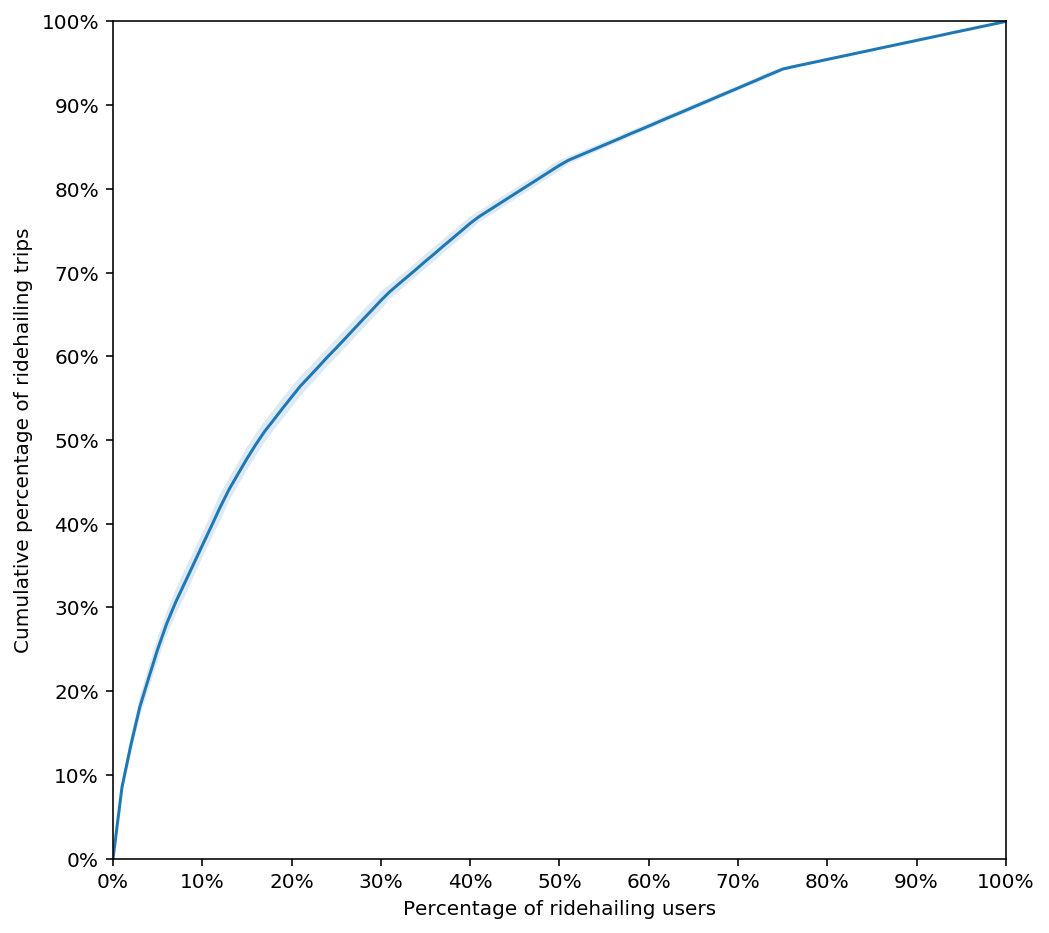

In [21]:
plt.figure(figsize=(8, 7.7))
oneormore = pers17[pers17.RIDESHARE >= 1].sort_values(by='RIDESHARE', ascending=False)

def computePercentiles (repWeightIdx):
    wgt = f'WTPERFIN{repWeightIdx}'
    # if someone's weight is 10, they represent 10 people, so multiply their tripmaking by 10
    cumsum = np.cumsum(oneormore.RIDESHARE * oneormore[wgt])
    cumsum /= cumsum.iloc[-1]
    pctiles = weighted_percentile(cumsum, np.arange(1, 100, 1), oneormore[wgt]) * 100
    return np.array([
        0,
        *pctiles.tolist(),
        100
    ])

# Take percentiles accounting for weight
cumulative = pd.DataFrame({
    'WTPERFIN': computePercentiles(''),
    **{
        f'WTPERFIN{i}': computePercentiles(i) for i in range(1, 99)
    }
})


cumulative['se'] = multiReplicateSE(cumulative, 'WTPERFIN', 2017)

plt.fill_between(np.arange(0, 101, 1), cumulative.WTPERFIN - cumulative.se * 1.96, cumulative.WTPERFIN + cumulative.se * 1.96, alpha=0.15)
plt.plot(np.arange(0, 101, 1), cumulative.WTPERFIN)
plt.xlabel('Percentage of ridehailing users')
plt.ylabel('Cumulative percentage of ridehailing trips')
plt.xticks(np.arange(0, 101, 10), [f'{i}%' for i in range(0, 101, 10)])
plt.yticks(np.arange(0, 101, 10), [f'{i}%' for i in range(0, 101, 10)])
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.savefig('../fig/proportion_of_trips.pdf', bbox_inches='tight')

In [22]:
# Print out the 50th percentile, for quoting in the paper
cumulative['moe'] = cumulative.se * 1.96
cumulative[['WTPERFIN', 'moe']].iloc[50]

WTPERFIN    82.809196
moe          0.646381
Name: 50, dtype: float64

## Per-capita usage of ridehailing and transit

This could be termed the "market penetration": the percentage of people who have used it in the last month. We compare the ridehailing number to the transit number in the paper.

In [23]:
for mode, attribute in [
    ('Ridehailing', 'RIDESHARE'),
    ('Public transit', 'PTUSED')
]:
    valid = pers17[pers17[attribute] >= 0]
    pcusage = np.sum(valid[valid[attribute] > 0].WTPERFIN) / np.sum(valid.WTPERFIN)
    se = estReplicateSE(
        lambda i: np.sum(valid[valid[attribute] > 0][f'WTPERFIN{i}']) / np.sum(valid[f'WTPERFIN{i}']),
        pcusage,
        year=2017
    )

    print(f'{mode} per-capita usage: {pcusage * 100:.2f} +/- {1.96 * 100 * se}')

Ridehailing per-capita usage: 9.81 +/- 0.43536850447541653
Public transit per-capita usage: 16.58 +/- 0.41179732645007294


# Ridehailing use per capita by geography

This uses the have you used ridehailing in the last 30 days variable, which has better sample coverage than trip data.

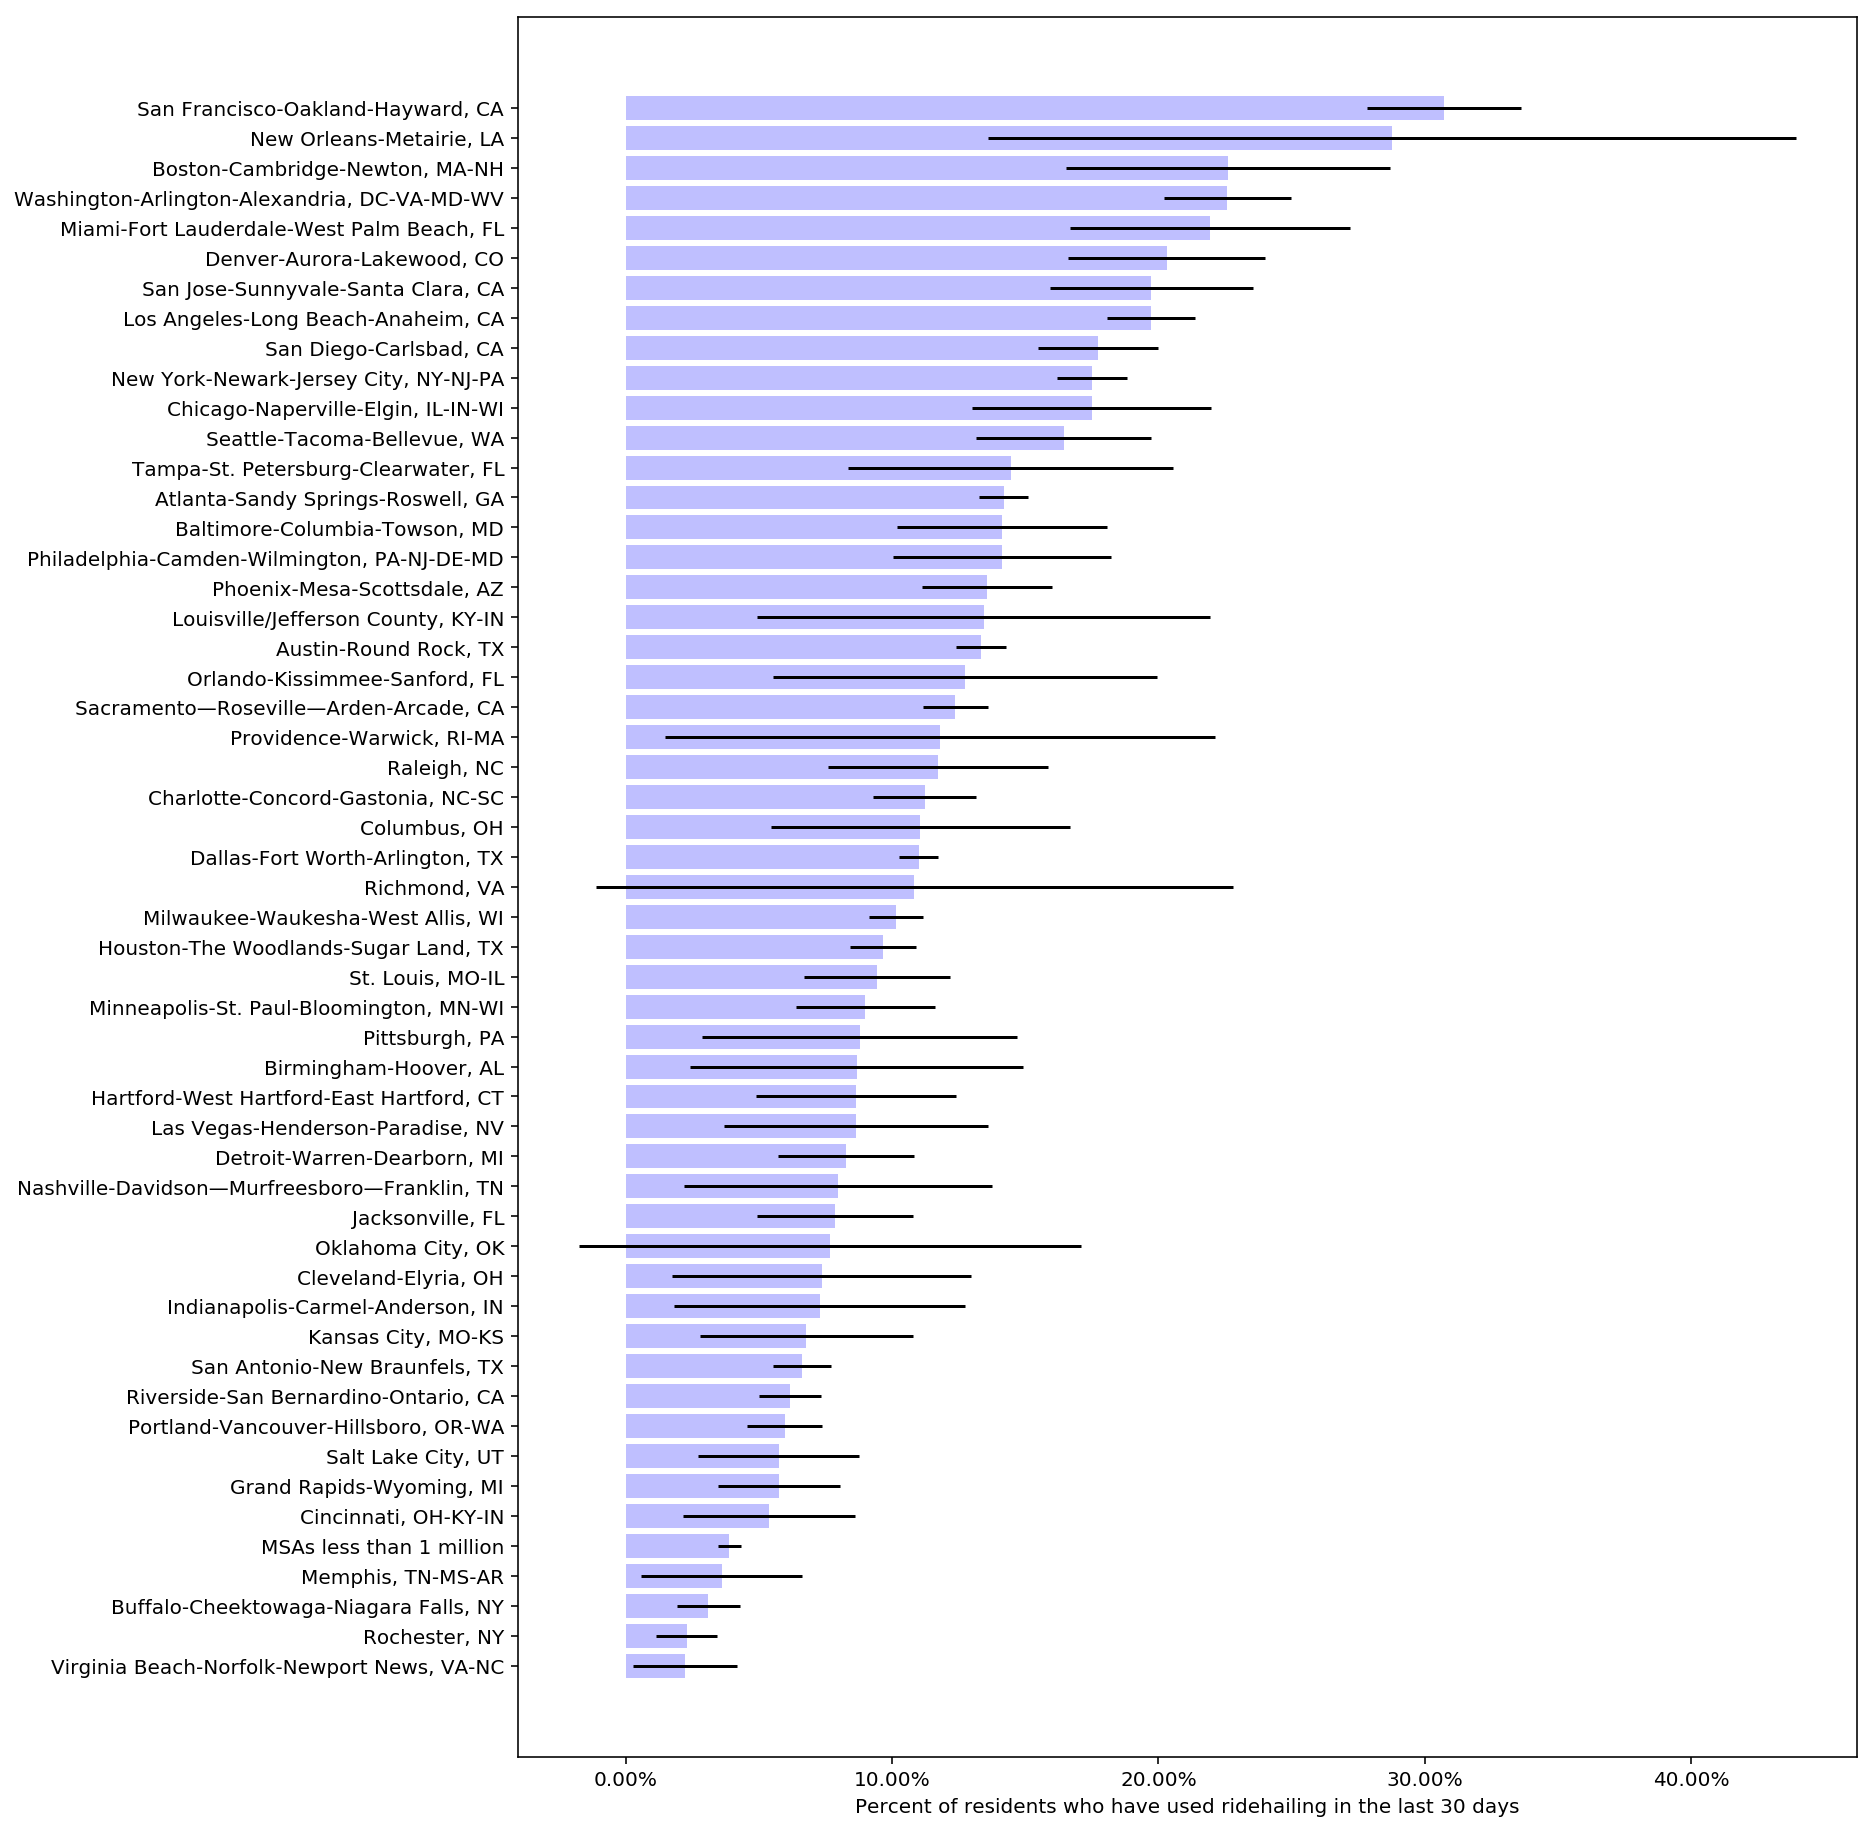

In [24]:
# rideshare >= 0: not missing data
# Rideshare > 0: used rideshare
pccbsa17 = pers17[pers17.RIDESHARE >= 0].groupby('cbsaName').agg({ 
    **{'WTPERFIN': lambda x: np.sum(x[pers17.loc[x.index].RIDESHARE > 0]) / np.sum(x) },
    **{f'WTPERFIN{i}': lambda x: np.sum(x[pers17.loc[x.index].RIDESHARE > 0]) / np.sum(x) for i in range(1, 99) }
})

pccbsa17['se'] = multiReplicateSE(pccbsa17, 'WTPERFIN', 2017)

fig, ax = plt.subplots(figsize=(12, 16))
pccbsa17.sort_values('WTPERFIN', inplace=True)
plt.barh(list(range(len(pccbsa17))), pccbsa17.WTPERFIN * 100, xerr=pccbsa17.se * 1.96 * 100, color='blue', alpha=0.25)
plt.yticks(list(range(len(pccbsa17))),
           [c.replace('--', '—')\
                   .replace('Suppressed', 'MSAs less than 1 million')
               for i, c in enumerate(pccbsa17.index)
           ])
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.2f}%'))
plt.xlabel('Percent of residents who have used ridehailing in the last 30 days')
plt.savefig('../fig/geogpercapita.pdf', bbox_inches='tight')
pass

In [25]:
# Print out as a table, we selectively quote a few values in the paper
pccbsa17['moe'] = 1.96 * pccbsa17['se']
(pccbsa17[['WTPERFIN', 'moe']].sort_values('WTPERFIN', ascending=False) * 100).round(2)

,WTPERFIN,moe
cbsaName,,
"San Francisco-Oakland-Hayward, CA",30.72,2.87
"New Orleans-Metairie, LA",28.77,15.17
"Boston-Cambridge-Newton, MA-NH",22.61,6.09
"Washington-Arlington-Alexandria, DC-VA-MD-WV",22.59,2.38
"Miami-Fort Lauderdale-West Palm Beach, FL",21.94,5.25
"Denver-Aurora-Lakewood, CO",20.30,3.71
"San Jose-Sunnyvale-Santa Clara, CA",19.73,3.80
"Los Angeles-Long Beach-Anaheim, CA",19.73,1.66
"San Diego-Carlsbad, CA",17.72,2.25
